In [1]:
import math
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn import preprocessing
from Training import model, utils, dataset, train
from sklearn.model_selection import train_test_split


import keras.backend as K

In [2]:
def check_acc(y_hat,y,margin=0.05):
    a_err = (np.abs(y_hat - y)) # get normalized error 
    err = np.divide(a_err, y, out=a_err, where=y!=0)
    assert(err.shape == y.shape)
    num_correct = 0
    for row in err:
        num_in_row = len(np.where(row < margin)[0]) # margin * 100 because 
        if num_in_row == len(row):
            num_correct += 1

    num_samples = y.shape[0]
    correct_idx = np.where(err < margin)
    num_part_correct = len(correct_idx[0])
    num_part_samples = y.shape[0] * y.shape[1]
    print(f"Correct = {num_correct} / {num_samples}")
    return (num_correct/num_samples)
from matplotlib.patches import Ellipse
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip
def multivariate_gaussian_nll(ypreds, ytrue, var):
    
    diag = torch.exp(var[:,:2]) # convert log-scale var to
    n = ypreds.shape[1] #number of parameters ie number of means (2 gain and bandwidth)
    B = ypreds.shape[0] #Batch size
    
    z = torch.zeros(B)
    o = torch.ones(B)
    D = torch.stack((diag[:,0],z,z,diag[:,1]),dim=1).reshape(B,2,2) # form Diagnol matrix D for LDLT
    L = torch.stack((o,z,var[:,2],o),dim=1).reshape(B,2,2) # form L matrix 
    LT = torch.stack((o,var[:,2],z,o),dim=1).reshape(B,2,2) # form LT matrix (transpose of L)

    sigma = L @ D @ LT   # form sigma inv from LDLT decomp
    ximu =(ytrue-ypreds).reshape(B,2,1)  #true- minus 
    ximuT =(ytrue-ypreds).reshape(B,1,2) # true- minus  transpose

    loss = 0.5*torch.mean(ximuT@sigma@ximu + ((n/2)*(-torch.sum(var[:,:2],axis=1).reshape(B,1))))
    return loss
def formCovMatrix(var):
    diag = np.exp(var[:2])
    z = np.zeros(2)
    o = np.ones(2)
    D = np.array([diag[0],0,0,diag[1]]).reshape(2,2)
    L = np.array([1,0,var[2],1]).reshape(2,2)
    LT = np.array([1,var[2],0,1]).reshape(2,2)
    sigma = L @ D @ LT
    return np.linalg.pinv(sigma)

In [3]:
data = utils.parseGainAndBWCsv2("Data/BW-3000.csv").astype(float)

In [4]:
data = preprocessing.MinMaxScaler((0,1)).fit_transform(data)
X = data[:,:2]
Y = data[:,2:]

In [41]:
test_gaussian_model = model.DistModelBatchNorm(2,5)

In [42]:
mock_simulator = tf.keras.models.load_model('mock_simulator2.0')

In [43]:
dataset1 = dataset.CircuitSynthesisGainAndBandwidthManually(Y, X)
train_dataset, val_dataset = utils.splitDataset(dataset1, 0.9)
    
train_data = DataLoader(train_dataset,batch_size = 500)
validation_data = DataLoader(val_dataset, batch_size = 500)

In [44]:
def reverse_check_accuracy(x_pred, y, threshold, simulator):

    final_g_preds = []
    for i in range(x_pred.shape[0]):
        means = x_pred.detach().numpy()[i,:2].T
        w,r = means
        y_hat = simulator(means.reshape(1,2)) 
        final_g_preds.append(y_hat)
    final_g_preds = np.array(final_g_preds).reshape(-1,2)
    y = np.array(y).reshape(-1, 2)

    accuracy = check_acc(y,final_g_preds,margin=threshold)
    
    return accuracy
    
    

In [45]:
optimizer_gaussian = optim.Adagrad(test_gaussian_model.parameters(),lr=0.001)
loss_gaussian_fn = multivariate_gaussian_nll

In [46]:
print(len(train_dataset))
print(len(val_dataset))

2719
303


In [47]:
train_accuracy_5 = []
train_accuracy_10 = []
train_accuracy_20 = []
validation_accuracy_5 = []
validation_accuracy_10 = []
validation_accuracy_20 = []

for epoch in range(1000):
    print('epoch {}'.format(epoch))
    test_gaussian_model.train()
    ta5 = 0
    ta10 = 0
    ta20 = 0
    va5 = 0
    va10 = 0
    va20 = 0
    for t, (x, y) in enumerate(train_data):
        x_var = torch.autograd.Variable(x.float())
        y_var = torch.autograd.Variable(y.float())

        optimizer_gaussian.zero_grad()
        scores = test_gaussian_model(x_var)
        inputs = scores[:,:2]
        var = scores[:,2:]
        loss = loss_gaussian_fn(inputs.float(), y_var.float(), var.float())

        print(loss.item())
        loss.backward()
        optimizer_gaussian.step()
        if (epoch + 1) % 100 == 0:
            ta5_t = reverse_check_accuracy(scores, x_var, 0.05, mock_simulator)
            ta10_t = reverse_check_accuracy(scores, x_var, 0.1, mock_simulator)
            ta20_t = reverse_check_accuracy(scores, x_var, 0.2, mock_simulator)

            ta5 += (ta5_t - ta5) / (t+1)
            ta10 += (ta10_t - ta10) / (t+1)
            ta20 += (ta20_t - ta20) / (t+1)
    if (epoch + 1) % 100 == 0:
        test_gaussian_model.eval()
        for t, (xv, yv) in enumerate(validation_data):
            xv_var = torch.autograd.Variable(xv.float())
            yv_var = torch.autograd.Variable(yv.float())

            # make predictions
            scores_val = test_gaussian_model(xv_var)


            va5_t = reverse_check_accuracy(scores_val, xv_var, 0.05, mock_simulator)
            va10_t = reverse_check_accuracy(scores_val, xv_var, 0.1, mock_simulator)
            va20_t = reverse_check_accuracy(scores_val, xv_var, 0.2, mock_simulator)   

            va5 += (va5_t - va5) / (t+1)
            va10 += (va10_t - va10) / (t+1)
            va20 += (va20_t - va20) / (t+1)
        train_accuracy_5.append(ta5)
        train_accuracy_10.append(ta10)
        train_accuracy_20.append(ta20)
        validation_accuracy_5.append(va5)
        validation_accuracy_10.append(va10)
        validation_accuracy_20.append(va20)

epoch 0
0.455073744058609
0.1619618833065033
0.08575805276632309
-0.06410534679889679
-0.17821632325649261
-0.2708721160888672
epoch 1
-0.3149581849575043
-0.37155768275260925
-0.4334476590156555
-0.4930936396121979
-0.5369158983230591
-0.5760018825531006
epoch 2
-0.5981702208518982
-0.6508730053901672
-0.6874900460243225
-0.7283011674880981
-0.7332226037979126
-0.7821656465530396
epoch 3
-0.8101022243499756
-0.8353331089019775
-0.8587545156478882
-0.8676674365997314
-0.8920332789421082
-0.9360963702201843
epoch 4
-0.9189546704292297
-0.9829103946685791
-1.013717770576477
-1.0011727809906006
-0.9896357655525208
-1.0545700788497925
epoch 5
-1.0780506134033203
-1.1093488931655884
-1.1127225160598755
-1.1297812461853027
-1.1325467824935913
-1.169026494026184
epoch 6
-1.1730213165283203
-1.2162971496582031
-1.2443231344223022
-1.2511905431747437
-1.2252353429794312
-1.2287521362304688
epoch 7
-1.2502636909484863
-1.2842503786087036
-1.285311222076416
-1.2788573503494263
-1.2897284030914307

-3.423950672149658
epoch 65
-3.451630115509033
-3.5316004753112793
-3.5556204319000244
-3.6268250942230225
-3.620115280151367
-3.5975353717803955
epoch 66
-3.499458074569702
-3.5074493885040283
-3.472506046295166
-3.554069757461548
-3.609361410140991
-3.711263418197632
epoch 67
-3.630774736404419
-3.6498379707336426
-3.6680545806884766
-3.6590449810028076
-3.6711807250976562
-3.709723711013794
epoch 68
-3.63569974899292
-3.7104580402374268
-3.6894021034240723
-3.6727395057678223
-3.742633581161499
-3.7762627601623535
epoch 69
-3.704963207244873
-3.7464759349823
-3.7202489376068115
-3.7029755115509033
-3.7159793376922607
-3.715473175048828
epoch 70
-3.643519401550293
-3.7164247035980225
-3.7101805210113525
-3.6854770183563232
-3.675508737564087
-3.7797982692718506
epoch 71
-3.7684264183044434
-3.7858524322509766
-3.719287395477295
-3.6911122798919678
-3.7464892864227295
-3.695505142211914
epoch 72
-3.3911545276641846
-3.455447196960449
-3.470085382461548
-3.551515579223633
-3.6445524692

-4.909254550933838
epoch 128
-4.804362773895264
-4.841798782348633
-4.636895179748535
-4.512845039367676
-4.6425604820251465
-4.499320030212402
epoch 129
-4.5933003425598145
-4.717486381530762
-4.492319107055664
-4.477700233459473
-4.265044212341309
-4.5739006996154785
epoch 130
-4.532487392425537
-4.61283540725708
-4.502413272857666
-4.242598533630371
-4.453128814697266
-4.499407768249512
epoch 131
-4.318656921386719
-4.414562702178955
-4.519077301025391
-4.71951150894165
-4.783225059509277
-4.792328834533691
epoch 132
-4.64149808883667
-4.709188938140869
-4.580597877502441
-4.698091983795166
-4.8833112716674805
-4.912580490112305
epoch 133
-4.776608943939209
-4.755029201507568
-4.726558208465576
-4.751781463623047
-4.694899559020996
-4.823556900024414
epoch 134
-4.646627902984619
-4.872996807098389
-4.853953838348389
-4.920567512512207
-4.931158065795898
-4.84665060043335
epoch 135
-4.686760902404785
-4.78774881362915
-4.7511115074157715
-4.856915473937988
-4.910461902618408
-4.97254

-5.292922496795654
-5.2240095138549805
-5.277589321136475
-5.389952182769775
-5.565403461456299
epoch 195
-5.446742057800293
-5.436097621917725
-5.298932075500488
-5.437606334686279
-5.435741424560547
-5.467730522155762
epoch 196
-5.454507350921631
-5.472654342651367
-5.296385288238525
-5.448779106140137
-5.50983190536499
-5.6555070877075195
epoch 197
-5.478917121887207
-5.597639560699463
-5.5070319175720215
-5.442897796630859
-5.497494697570801
-5.685963153839111
epoch 198
-5.5439348220825195
-5.617961406707764
-5.505052089691162
-5.564929008483887
-5.576869010925293
-5.575954914093018
epoch 199
-5.513246059417725
Correct = 102 / 500
Correct = 177 / 500
Correct = 335 / 500
-5.544844150543213
Correct = 119 / 500
Correct = 235 / 500
Correct = 366 / 500
-5.462416648864746
Correct = 103 / 500
Correct = 205 / 500
Correct = 352 / 500
-5.534534931182861
Correct = 186 / 500
Correct = 307 / 500
Correct = 405 / 500
-5.56397819519043
Correct = 123 / 500
Correct = 245 / 500
Correct = 417 / 500
-5

-5.6821746826171875
-5.539745330810547
-5.658134460449219
-5.791317939758301
-5.997704982757568
epoch 258
-5.836140155792236
-5.859315872192383
-5.657894611358643
-5.648616790771484
-5.664183616638184
-5.906338691711426
epoch 259
-5.955374717712402
-6.0157999992370605
-5.848874092102051
-5.816542148590088
-5.872151851654053
-5.981017112731934
epoch 260
-5.752047538757324
-5.934409141540527
-5.918467044830322
-5.997372627258301
-6.039058208465576
-6.134807586669922
epoch 261
-5.948495864868164
-5.990187644958496
-5.757984161376953
-5.800255298614502
-5.8159098625183105
-5.968806743621826
epoch 262
-5.994844913482666
-6.007404804229736
-5.813620090484619
-5.800266265869141
-5.779116630554199
-5.738076686859131
epoch 263
-5.581470966339111
-5.9014129638671875
-5.794469356536865
-5.699225425720215
-5.68099308013916
-5.941736698150635
epoch 264
-5.8271708488464355
-5.867842197418213
-5.533414363861084
-5.570230960845947
-5.3341898918151855
-5.423948287963867
epoch 265
-4.957597732543945
-5.

-5.873691082000732
-5.921513557434082
-5.934475898742676
-5.904521465301514
epoch 321
-5.707845687866211
-6.180683612823486
-6.1797404289245605
-6.262170314788818
-6.224035263061523
-6.256805896759033
epoch 322
-5.945913314819336
-6.107274532318115
-5.9164137840271
-5.991440296173096
-6.172255039215088
-6.416680812835693
epoch 323
-6.246308326721191
-6.317208766937256
-6.028822898864746
-5.978488445281982
-6.082498073577881
-6.2566375732421875
epoch 324
-6.216686725616455
-6.327800273895264
-6.188845634460449
-6.246695041656494
-6.213149070739746
-6.3405585289001465
epoch 325
-6.11931037902832
-6.345649719238281
-6.195393085479736
-6.3403730392456055
-6.327114105224609
-6.438154220581055
epoch 326
-6.091141700744629
-6.137251853942871
-5.933616638183594
-6.100229263305664
-6.151727199554443
-6.372463226318359
epoch 327
-6.190138339996338
-6.3054375648498535
-6.106667995452881
-6.220723628997803
-6.214666843414307
-6.268349647521973
epoch 328
-6.023544788360596
-6.187811851501465
-6.052

-6.363152027130127
-6.261527061462402
-6.374759197235107
-6.350379943847656
-6.294050216674805
epoch 388
-6.172676086425781
-6.3490214347839355
-6.212947845458984
-6.331195831298828
-6.159923076629639
-6.421706676483154
epoch 389
-6.256168365478516
-6.365917205810547
-6.2266950607299805
-6.073671340942383
-6.10077428817749
-6.240314960479736
epoch 390
-6.158905029296875
-6.2815680503845215
-5.954380989074707
-6.175736904144287
-6.298243999481201
-6.308088779449463
epoch 391
-6.207359790802002
-6.476522445678711
-6.21509313583374
-6.310009479522705
-6.377521991729736
-6.658312797546387
epoch 392
-6.416171550750732
-6.461915016174316
-6.279803276062012
-6.160425186157227
-6.352766990661621
-6.585335731506348
epoch 393
-6.4870285987854
-6.572178840637207
-6.303373336791992
-6.357006549835205
-6.3867340087890625
-6.448523044586182
epoch 394
-6.153995990753174
-6.558587551116943
-6.445365905761719
-6.481627464294434
-6.4645586013793945
-6.278862476348877
epoch 395
-6.139623641967773
-6.3779

-6.332847595214844
-6.206243515014648
-6.336688041687012
-6.479058742523193
epoch 451
-6.355093479156494
-6.551854133605957
-6.24995756149292
-6.4824957847595215
-6.5109758377075195
-6.592935085296631
epoch 452
-6.25042200088501
-6.518145561218262
-6.356164932250977
-6.481477737426758
-6.722898960113525
-6.873495101928711
epoch 453
-6.555665493011475
-6.675191879272461
-6.508126735687256
-6.5421037673950195
-6.460976600646973
-6.537240982055664
epoch 454
-6.613156795501709
-6.776617050170898
-6.639433860778809
-6.784811019897461
-6.686277866363525
-6.767159938812256
epoch 455
-6.519787788391113
-6.597546577453613
-6.633182048797607
-6.742944717407227
-6.789318084716797
-6.906374454498291
epoch 456
-6.614382266998291
-6.799644470214844
-6.652593612670898
-6.763442039489746
-6.726371765136719
-6.706575393676758
epoch 457
-6.300886154174805
-6.7923126220703125
-6.59335470199585
-6.670379161834717
-6.581167221069336
-6.7544965744018555
epoch 458
-6.528041362762451
-6.711301803588867
-6.624

-6.644830703735352
-6.3058037757873535
-6.526968002319336
-6.563681125640869
-6.702878475189209
epoch 514
-6.581028938293457
-6.664682865142822
-6.13783597946167
-6.010697364807129
-5.564966201782227
-6.131852626800537
epoch 515
-6.020936012268066
-6.378627777099609
-6.282723903656006
-6.243250846862793
-6.1232733726501465
-6.474997043609619
epoch 516
-6.2434515953063965
-6.500871658325195
-6.483370304107666
-6.651655673980713
-6.591610431671143
-6.5304856300354
epoch 517
-6.262131214141846
-6.519612789154053
-6.362442493438721
-6.633289337158203
-6.878058910369873
-6.968870639801025
epoch 518
-6.74088716506958
-6.711052894592285
-6.201559543609619
-6.445374965667725
-6.7511305809021
-6.888696193695068
epoch 519
-6.707989692687988
-6.845694065093994
-6.685753345489502
-6.674905300140381
-6.638988494873047
-6.5988874435424805
epoch 520
-6.5086588859558105
-6.838470935821533
-6.673234939575195
-6.753820419311523
-6.77714204788208
-6.902292251586914
epoch 521
-6.7430315017700195
-6.904765

-6.594733715057373
-6.457505226135254
-6.470310211181641
-6.610273361206055
epoch 580
-6.163291931152344
-6.8917341232299805
-6.751743793487549
-6.875927448272705
-6.7223310470581055
-6.785810470581055
epoch 581
-6.65723180770874
-6.9047346115112305
-6.765643119812012
-6.920839786529541
-6.8541460037231445
-7.133680820465088
epoch 582
-6.9964189529418945
-7.125041484832764
-6.917102813720703
-6.933969974517822
-6.891197681427002
-7.0334882736206055
epoch 583
-6.774937629699707
-7.049376010894775
-6.910274028778076
-6.976112365722656
-6.92067813873291
-7.05746603012085
epoch 584
-6.9526448249816895
-7.112332820892334
-6.976747989654541
-7.085992813110352
-6.916152000427246
-7.02556037902832
epoch 585
-6.96316385269165
-7.145801067352295
-7.0698018074035645
-7.164513111114502
-7.04876708984375
-7.213925838470459
epoch 586
-6.972253799438477
-7.0957159996032715
-6.9712300300598145
-7.075139045715332
-7.0873703956604
-7.231929779052734
epoch 587
-6.99259614944458
-7.160092830657959
-6.9498

-7.083831787109375
-7.071968078613281
-7.387875080108643
epoch 643
-7.1775007247924805
-7.237458229064941
-7.003299713134766
-7.068800926208496
-7.025288105010986
-7.340725898742676
epoch 644
-7.04906702041626
-7.215723991394043
-7.0084099769592285
-7.0773820877075195
-6.994531154632568
-7.112687110900879
epoch 645
-6.876193523406982
-7.114181995391846
-6.94929838180542
-6.8834638595581055
-6.950408935546875
-7.288986682891846
epoch 646
-7.054235458374023
-7.036559104919434
-6.777392864227295
-6.769652843475342
-6.887625694274902
-7.193795680999756
epoch 647
-6.9603095054626465
-7.202519416809082
-6.8714280128479
-6.859853267669678
-6.713315010070801
-6.649259090423584
epoch 648
-6.639471530914307
-7.0227460861206055
-6.831544876098633
-6.948376655578613
-6.875946521759033
-6.975881576538086
epoch 649
-6.79813289642334
-6.850441932678223
-6.5784687995910645
-6.670553207397461
-6.792736530303955
-6.849864482879639
epoch 650
-6.606982231140137
-7.212719440460205
-6.932302951812744
-6.851

-7.1939568519592285
epoch 706
-6.838109493255615
-6.968730926513672
-6.679586410522461
-7.052199840545654
-7.008674144744873
-7.116055011749268
epoch 707
-7.081662178039551
-7.161203861236572
-6.886275291442871
-6.956980228424072
-6.787079334259033
-7.148472785949707
epoch 708
-7.019890308380127
-7.197353839874268
-7.03156042098999
-6.985050201416016
-7.015603542327881
-7.200803756713867
epoch 709
-7.0176520347595215
-7.24894905090332
-7.06231689453125
-7.088531494140625
-6.9883551597595215
-7.139049053192139
epoch 710
-7.162508964538574
-7.352016925811768
-7.163074016571045
-7.179158687591553
-7.060820579528809
-7.132444381713867
epoch 711
-7.059293270111084
-7.2989115715026855
-7.156006813049316
-7.2731451988220215
-7.137767791748047
-7.269266128540039
epoch 712
-7.055429458618164
-7.17841911315918
-6.882561206817627
-7.025486946105957
-7.08739709854126
-7.412709712982178
epoch 713
-7.100432872772217
-7.2340850830078125
-7.0026702880859375
-7.055118560791016
-7.129275798797607
-7.395

-7.139474868774414
-7.175601959228516
-6.66165018081665
-6.741354942321777
-6.563907623291016
-6.695140361785889
epoch 773
-6.720004081726074
-6.743261337280273
-6.642323017120361
-6.747658729553223
-6.573574066162109
-6.856648921966553
epoch 774
-6.6707072257995605
-6.870781898498535
-6.596065998077393
-6.640545845031738
-6.3334832191467285
-6.795302867889404
epoch 775
-6.4226813316345215
-6.669604778289795
-6.508890151977539
-6.77987813949585
-6.871352672576904
-7.188997268676758
epoch 776
-7.010878086090088
-6.9706244468688965
-6.5718865394592285
-6.232824802398682
-6.782647132873535
-7.340185165405273
epoch 777
-7.128504276275635
-7.372542381286621
-7.087037086486816
-7.0372843742370605
-6.844601154327393
-7.24332332611084
epoch 778
-7.003180027008057
-7.366518497467041
-7.213355541229248
-7.233358383178711
-7.020050525665283
-7.193648815155029
epoch 779
-7.244635581970215
-7.443343162536621
-7.266683101654053
-7.359139919281006
-7.261508464813232
-7.307602882385254
epoch 780
-7.11

-7.026142120361328
-6.936428546905518
-7.262418270111084
epoch 836
-7.1485090255737305
-7.20999813079834
-6.928530216217041
-7.028327941894531
-6.852845191955566
-7.009713172912598
epoch 837
-7.2442193031311035
-7.467702388763428
-7.1762590408325195
-7.2310051918029785
-6.958480358123779
-7.096078872680664
epoch 838
-6.89090633392334
-7.442454814910889
-7.3646955490112305
-7.398902893066406
-7.248962879180908
-7.587676525115967
epoch 839
-7.22954797744751
-7.446413516998291
-7.321177005767822
-7.457101345062256
-7.41021728515625
-7.640417575836182
epoch 840
-7.365197658538818
-7.469221115112305
-7.205819606781006
-7.418814182281494
-7.306910514831543
-7.630277156829834
epoch 841
-7.448517322540283
-7.632253170013428
-7.427225112915039
-7.441467761993408
-7.25899076461792
-7.614867210388184
epoch 842
-7.307722091674805
-7.556033134460449
-7.455804347991943
-7.552095890045166
-7.442842483520508
-7.681123733520508
epoch 843
-7.269257545471191
-7.247450828552246
-6.822185039520264
-7.17228

Correct = 283 / 500
Correct = 386 / 500
Correct = 458 / 500
-7.533729076385498
Correct = 128 / 219
Correct = 169 / 219
Correct = 212 / 219
Correct = 181 / 303
Correct = 217 / 303
Correct = 269 / 303
epoch 900
-7.443596363067627
-7.463003158569336
-7.196575164794922
-7.391018867492676
-7.242888927459717
-7.500136852264404
epoch 901
-7.440377712249756
-7.63776159286499
-7.4267048835754395
-7.548460483551025
-7.38991117477417
-7.6175761222839355
epoch 902
-7.336677551269531
-7.586257457733154
-7.45840311050415
-7.583442211151123
-7.569980144500732
-7.843486785888672
epoch 903
-7.580796718597412
-7.633710861206055
-7.432643890380859
-7.488113880157471
-7.409464359283447
-7.684510707855225
epoch 904
-7.502877235412598
-7.717527866363525
-7.550917148590088
-7.573462963104248
-7.328150272369385
-7.51480770111084
epoch 905
-7.244707107543945
-7.498009204864502
-7.378649711608887
-7.529533386230469
-7.477108955383301
-7.669585704803467
epoch 906
-7.435502529144287
-7.543272018432617
-7.33696317

-7.550358772277832
epoch 965
-7.367969036102295
-7.596886157989502
-7.463339805603027
-7.577070236206055
-7.544151782989502
-7.844060897827148
epoch 966
-7.528054237365723
-7.659943103790283
-7.467738151550293
-7.536961078643799
-7.596429824829102
-7.8954315185546875
epoch 967
-7.616857528686523
-7.6858367919921875
-7.453816890716553
-7.394070625305176
-7.299253463745117
-7.43017053604126
epoch 968
-7.359955787658691
-7.477334499359131
-7.258401870727539
-7.440789222717285
-7.346907138824463
-7.441056251525879
epoch 969
-7.4238128662109375
-7.45075798034668
-7.054493427276611
-7.255566120147705
-7.39876127243042
-7.705597877502441
epoch 970
-7.454890727996826
-7.556276798248291
-7.3264546394348145
-7.289007186889648
-7.235694885253906
-7.556156158447266
epoch 971
-7.142024517059326
-7.324454307556152
-7.182848930358887
-7.22036600112915
-7.08123254776001
-6.868226051330566
epoch 972
-6.660661220550537
-6.957294464111328
-6.6823039054870605
-7.043811798095703
-7.05550479888916
-7.110912

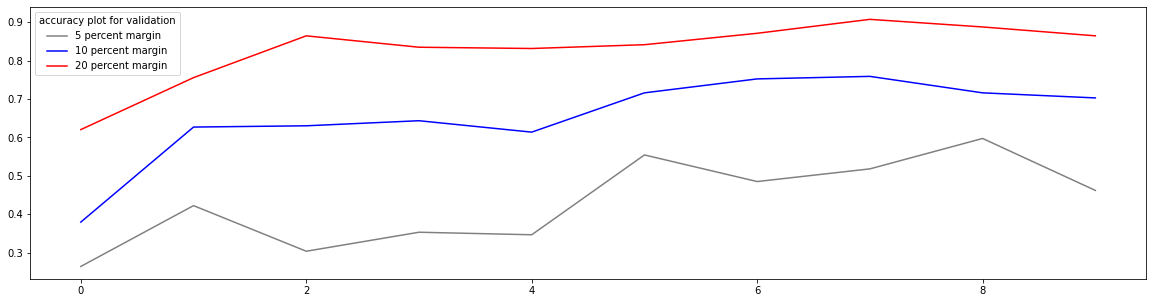

In [48]:
plt.figure(figsize=(20,5))
plt.plot(validation_accuracy_5, color='grey', label='5 percent margin')
plt.plot(validation_accuracy_10, color='blue', label = '10 percent margin')
plt.plot(validation_accuracy_20, color='red', label = '20 percent margin')
plt.legend(title = 'accuracy plot for validation')
plt.show()

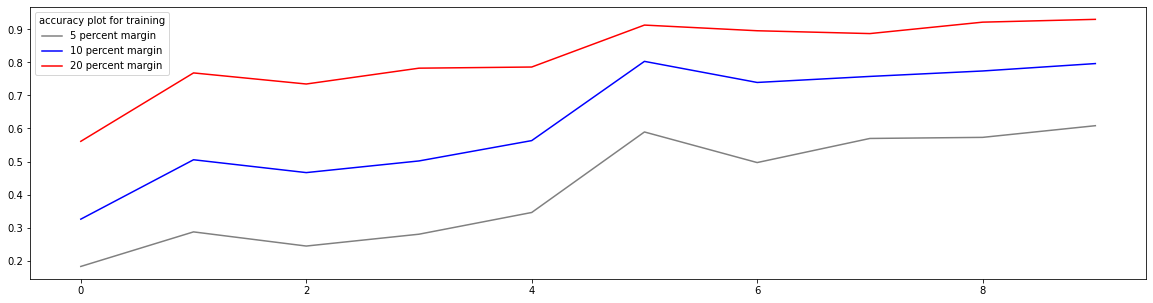

In [49]:
plt.figure(figsize=(20,5))
plt.plot(train_accuracy_5, color='grey', label='5 percent margin')
plt.plot(train_accuracy_10, color='blue', label = '10 percent margin')
plt.plot(train_accuracy_20, color='red', label = '20 percent margin')
plt.legend(title = 'accuracy plot for training')
plt.show()